In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

In [2]:
from motion.detect_human import BBoxDataset

I used [sloth](https://github.com/cvhciKIT/sloth) to annotate the images.

You can find the config file in the `data` folder (`sloth_config.py`). The command to start `sloth` that I used was: `sloth --config sloth_config.py annotations.json`. I ran the command from within the directory where I stored my train images (both the `sloth_config.py` and `annotations.json` files were inside the directory as well).

In [3]:
SZ = 500

In [4]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb
def visualize(sample):
    
    return plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(255, 0, 0),3)
    return img
    

In [5]:
trn_ds = BBoxDataset("coco/train2017_one_human.csv", size = SZ, type = "train")
# trn_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "train")
val_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "valid")
# val_ds = BBoxDataset("coco/val2017_one_human_val.csv", size = SZ, type = "valid")
# val_ds = BBoxDataset("motion/detect_human/one_sample_dataset.csv", size = SZ, type = "valid")
val_ds[0][0].mean()

Dataset has 27885 samples.
Dataset has 925 samples.


0.19446708

In [6]:
NUM_WORKERS=5
BS = 64

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [7]:
from motion.detect_human import HumanBBox

In [8]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [9]:
def l1(preds, targs):
    return L1Loss()(preds, targs).mean()
def iou_loss(preds, targs):
    return 1.0-IoU(preds, targs).mean()

def iou_custom_loss(preds, targs):
    loss = iou_loss(preds,targs)
    l1_loss = l1(preds,targs)
    loss += 3*l1_loss
    return loss*100

In [10]:
learn = Learner(data_bunch, HumanBBox(), loss_func=iou_custom_loss)
learn.metrics = [l1,iou_loss ]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


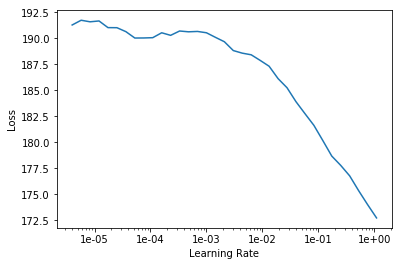

In [11]:
learn.lr_find(num_it = 50)
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(2, 3e-2)

epoch,train_loss,valid_loss,l1,iou_loss
1,109.715927,104.559166,0.139258,0.627816
2,97.256592,98.302635,0.130100,0.592728


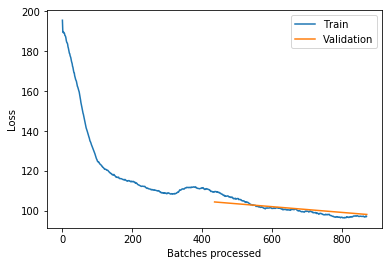

In [13]:
learn.recorder.plot_losses()

In [14]:
learn.validate()

[98.302635, tensor(0.1301), tensor(0.5927)]

In [15]:
learn.save('detect_humans_res18_arch2-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


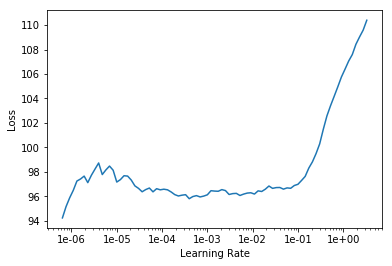

In [16]:
learn.lr_find(num_it = 100)
learn.recorder.plot()

Stopped here. Data probally to diverce to train on.

In [17]:
preds, targs = learn.get_preds()

Let's take a look at the results.

In [18]:
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()
predicted_bboxes

array([[ 48.454395, 122.99247 , 294.9964  , 417.21573 ],
       [ 64.6889  ,  46.427788, 475.80054 , 445.45798 ],
       [112.71494 , 120.54895 , 358.71738 , 395.95935 ],
       [149.17932 , 141.7343  , 387.3608  , 427.7065  ],
       ...,
       [ 57.0673  , 125.85218 , 401.9595  , 462.17014 ],
       [ 23.367111, 150.08862 , 252.35564 , 450.4951  ],
       [ 88.603355,  82.46973 , 353.95917 , 396.277   ],
       [129.23347 , 145.70288 , 295.36157 , 342.04788 ]], dtype=float32)

In [19]:
targs*SZ

tensor([[275., 193., 499., 457.],
        [  0.,  63., 499., 429.],
        [214., 203., 318., 411.],
        ...,
        [ 49.,  60., 221., 425.],
        [144.,  80., 499., 446.],
        [  0., 222., 255., 408.]])

In [20]:
def draw_bbox(img, bbox, target=None, color= (255, 0, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 255, 3)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=3)
    return img

def visualize(sample, target = None):
    
    im = plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=3)
    return im
    

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(0, 255, 0),3)
    return img


(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


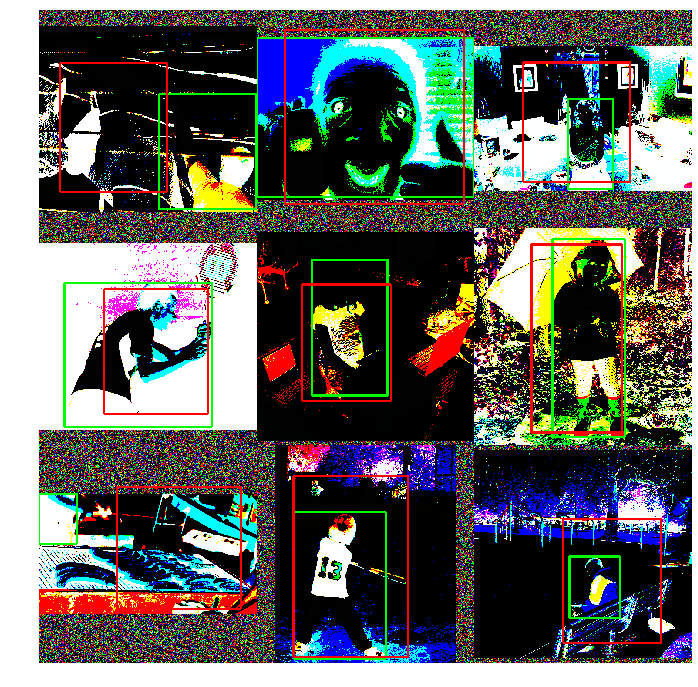

In [21]:
ims = np.stack([visualize(val_ds[i],target= predicted_bboxes[i]) for i in range(0,9)])
# ims = visualize(val_ds[0],target= predicted_bboxes[0])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))
# plt.imshow(np.stack(ims))

In [22]:
del learn

In [24]:
learn = Learner(data_bunch, HumanBBox(), loss_func=iou_custom_loss)
learn.metrics = [l1,iou_loss ]
learn.load('detect_humans_res18_arch2-1')

Learner(data=DataBunch;

Train: <motion.detect_human.bbox_dataset.BBoxDataset object at 0x7fea2743f9b0>;

Valid: <motion.detect_human.bbox_dataset.BBoxDataset object at 0x7fea2743fa20>;

Test: None, model=HumanBBox(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (in_between): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=(32, 32))
      (mp): AdaptiveMaxPool2d(output_size=(32, 32))
    )
  )
  (cnn2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (3): Flatten()
  )
  (head): Sequential(
    (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.25)
    (2): Linear(in_features=4096, out_features=512,

In [39]:
PATH = 'models/detect_humans_res18_arch2.pt'
torch.save(learn.model.state_dict(), PATH)

In [38]:
mdl = torch.load(PATH)
dir(mdl)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cnn',
 'cnn2',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'head',
 'in_between',
 'load_state_dict